reduced dataset info (10.0%): (2132, 128, 128, 3), (2132,)
train: (1385, 128, 128, 3), val: (522, 128, 128, 3), test: (225, 128, 128, 3)


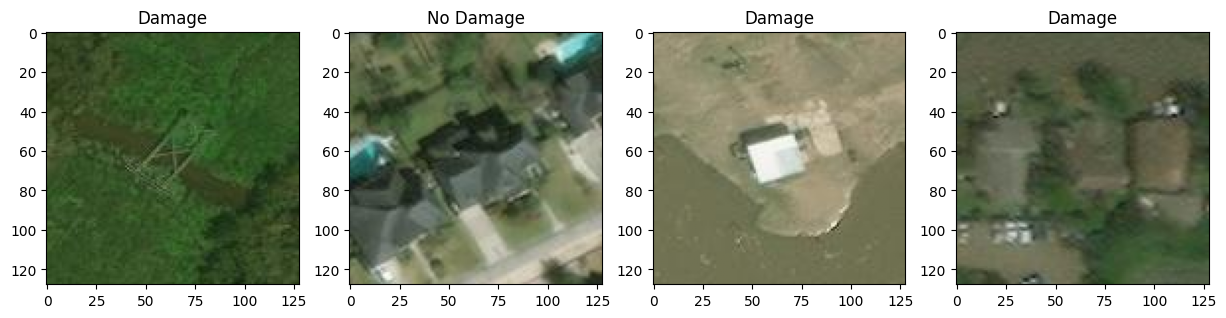

In [ ]:
# stuff
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
random.seed(42)

# folder paths (using absolute paths on local machine m4 macbbook pro)
damage_dir = "/Users/vnacham/coe379L python notebooks/project2/damage"
no_damage_dir = "/Users/vnacham/coe379L python notebooks/project2/no_damage"


damage_files = [f for f in os.listdir(damage_dir) if f.endswith(('.jpeg', '.png'))]
no_damage_files = [f for f in os.listdir(no_damage_dir) if f.endswith(('.jpeg', '.png'))]

# sample reduced amount (stratified) (using 20% here due to oom issues, in reality I would use 1.0 if I was submitting this as my best model)
red_amount = 0.1  # 20%
damage_sample = random.sample(damage_files, int(len(damage_files) * red_amount))
no_damage_sample = random.sample(no_damage_files, int(len(no_damage_files) * red_amount))


X = []
y = []
for f in damage_sample:
    # resizes here are for testing, do not need to resize normally, image is already 128x128
    img = Image.open(os.path.join(damage_dir, f)).resize((128, 128))  
    X.append(np.array(img) / 255.0)
    y.append(1)
for f in no_damage_sample:
    # resizes here are for testing, do not need to resize normally, image is already 128x128
    img = Image.open(os.path.join(no_damage_dir, f)).resize((128, 128))  
    X.append(np.array(img) / 255.0)
    y.append(0)

X = np.array(X)
y = np.array(y)

print(f"reduced dataset info ({red_amount*100}%): {X.shape}, {y.shape}")

# split is 65% train, 24.5% val, 10.5% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

print(f"train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

# sample vizs
fig, axes = plt.subplots(1, 4, figsize=(15, 7.5))
for i in range(4):
    axes[i].imshow(X_train[i])
    axes[i].set_title('Damage' if y_train[i] == 1 else 'No Damage')
plt.show()

In [6]:
import tensorflow as tf

# again, running on local macbook, using m4 metal mpu accelerator for faster training
print("gpu's available: ", len(tf.config.list_physical_devices('GPU')))
print("gpu devices: ", tf.config.list_physical_devices('GPU'))


from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import classification_report
import psutil

import gc # python garbage collector for memory managment


# dense ann
def dense_ann(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# lenet-5
act = 'relu'
def lenet5(input_shape):
    model = Sequential([
        Conv2D(6, (5, 5), activation=act, input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation=act),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation=act),
        Dense(84, activation=act),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# modified lenet-5 (filter change + droupout for even training), straight copied from the paper
def mod_lenet5(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'), 
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'), 
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),  # dropout layer
        Dense(512, activation='relu'),  
        Dense(1, activation='sigmoid')  # 1, bunary classificatoin
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)

# train models 
models = {
    'Dense ANN': dense_ann(input_shape),
    'LeNet-5': lenet5(input_shape),
    'Alt-LeNet-5': mod_lenet5(input_shape),
}

results = {}
for name, model in models.items():
    print(f"training {name}...")

    # track ram usage for debugging (had lots of oom issues with dataset loaded into ram)
    print(f"ram used: {psutil.virtual_memory().percent}%")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16, verbose=1)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[name] = test_acc
    print(f"{name} test accuracy: {test_acc}")

# select best model and save it
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"btest model: {best_model_name} with accuracy {results[best_model_name]}")

# Save best model
best_model.save('best_model.keras')

gc.collect()



gpu's available:  1
gpu devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
training Dense ANN...
ram used: 74.2%
Epoch 1/5
87/87 [==============================] - 2s 20ms/step - loss: 40.6816 - accuracy: 0.5437 - val_loss: 58.0423 - val_accuracy: 0.6648
Epoch 2/5
87/87 [==============================] - 1s 10ms/step - loss: 34.3427 - accuracy: 0.5509 - val_loss: 4.6469 - val_accuracy: 0.3697
Epoch 3/5
87/87 [==============================] - 1s 10ms/step - loss: 25.1549 - accuracy: 0.5661 - val_loss: 3.6407 - val_accuracy: 0.3831
Epoch 4/5
87/87 [==============================] - 1s 11ms/step - loss: 19.5521 - accuracy: 0.5653 - val_loss: 7.2856 - val_accuracy: 0.6648
Epoch 5/5
87/87 [==============================] - 1s 11ms/step - loss: 19.4112 - accuracy: 0.5574 - val_loss: 3.8051 - val_accuracy: 0.6648
Dense ANN test accuracy: 0.6622222065925598
training LeNet-5...
ram used: 75.7%
Epoch 1/5
87/87 [==============================] - 2s 15ms/step - loss: 0.7

22765

# SwinT transfromer model code below. it's done in pytorch (tf's wrapper for the model was not working well for me)

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import SwinForImageClassification, SwinConfig, AutoImageProcessor
from tqdm import tqdm  # progress bars
from torch.optim.lr_scheduler import StepLR  # LR decay
from torchvision import transforms

random.seed(42)

from torch.utils.data import Dataset

# custom image dataset class, handles lazy loading adn transformaations
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None, processor=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).resize((224, 224))  # Resize here
        if self.transform:
            img = self.transform(img)
        if self.processor:
            inputs = self.processor(img, return_tensors="pt")
            img = inputs['pixel_values'].squeeze(0)
        label = self.labels[idx]
        return img, label


# folder paths
damage_dir = "/Users/vnacham/coe379L python notebooks/project2/damage"
no_damage_dir = "/Users/vnacham/coe379L python notebooks/project2/no_damage"

# image paths
damage_files = [os.path.join(damage_dir, f) for f in os.listdir(damage_dir) if f.endswith(('.jpeg', '.png'))]
no_damage_files = [os.path.join(no_damage_dir, f) for f in os.listdir(no_damage_dir) if f.endswith(('.jpeg', '.png'))]

# sample reduced amount (stratified) (i actually use the full dataset here)
red_amount = 0.1
damage_sample = random.sample(damage_files, int(len(damage_files) * red_amount))
no_damage_sample = random.sample(no_damage_files, int(len(no_damage_files) * red_amount))

# combine the files 
all_files = damage_sample + no_damage_sample
all_labels = [1] * len(damage_sample) + [0] * len(no_damage_sample)

# Split file lists and labels
train_files, temp_files, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=0.35, random_state=42, stratify=all_labels)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# load processor for resizing/normalization
processor = AutoImageProcessor.from_pretrained('microsoft/swin-tiny-patch4-window7-224')

# additional image augmentations to make training more resistant
# theory behind this is that the drone/birds-eye-view captures could theoretically be captured at any orientation and also flipped
# thus augmenting the data is a completely safe idea and only makes our data more resistant to overfitting
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),    
    transforms.RandomRotation(degrees=[0, 270]),  # random rotations between 0 and 270 degrees
])

train_dataset = ImageDataset(train_files, train_labels, transform=train_transform, processor=processor)
val_dataset = ImageDataset(val_files, val_labels, processor=processor)
test_dataset = ImageDataset(test_files, test_labels, processor=processor)

# create dataloaders from my dataset classes
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# setting device to mps (training on macbook)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")


# loading the preconfigured swin model (pretrained on imagenet i beileve)
config = SwinConfig.from_pretrained('microsoft/swin-tiny-patch4-window7-224', num_labels=2)
model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224', config=config, ignore_mismatched_sizes=True)
model.to(device)

# training in two stages

# stage 1: freezing the backbone, and only training the head
#    # reasoning: original swint transformer weights for the head were for predicting imagenet outputs (1000 classes)
#    # we only want to predict 2. so we need to retrain the head to adapt to the feature extraction capabilities that the backbone has learned

# stage 2: fine-tuning the full model
#    # reasoning: we can fine-tune the entire model to improve further performance, because we now know the head has learned to adapt to the extracted features
#    # we also use a much lower lr to avoid destroying the learned weights

for param in model.swin.parameters():
    param.requires_grad = False  # freeze swin backbone
for param in model.classifier.parameters():
    param.requires_grad = True  # unfreeze head

# loss, optimizer, scheduler. higher LR for stage 1, because it's just the head (we will also finetune later)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # higher LR for stage 1
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # decay LR every 5 epochs

print("training head, stage 1:")
epochs_stage1 = 12 # picked a random number lol good enough
for epoch in range(epochs_stage1):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"epoch {epoch+1}/{epochs_stage1}", unit="batch") as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = outputs.logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            
            t.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")
    
    scheduler.step()  # lr update
    train_acc = correct / total
    
    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # no grad for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.logits, labels).item()
            pred = outputs.logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    
    print(f"Epoch {epoch+1}/{epochs_stage1} - {len(train_loader)}/{len(train_loader)} - loss: {train_loss/len(train_loader):.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss/len(val_loader):.4f} - val_accuracy: {correct/total:.4f}")



# stage 2 unfreeze all weights and train the full model with a lower LR
for param in model.parameters():
    param.requires_grad = True  # unfreeze all

# update optimizer with lower LR
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # reset scheduler

print("stage 2: fine-tuning full model...")
epochs_stage2 = 12
best_val_acc = 0.0
best_model_path = 'best_swin_model.pth'
for epoch in range(epochs_stage2):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"epoch {epoch+1}/{epochs_stage2}", unit="batch") as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = outputs.logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            
            t.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.4f}")
    
    scheduler.step()  # update LR
    train_acc = correct / total

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # dont update weights
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            outputs = model(inputs)
            val_loss += criterion(outputs.logits, labels).item()
            pred = outputs.logits.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    # commenting out save logic, just in case i override my best model by accident (this code was uncommented in my real run)
    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), best_model_path)
    #     print(f"new best model saved with val_acc: {val_acc:.4f}") # saving best validation model, prevents overfitting
    
    print(f"epoch {epoch+1}/{epochs_stage2} - {len(train_loader)}/{len(train_loader)} - loss: {train_loss/len(train_loader):.4f} - accuracy: {train_acc:.4f} - val_loss: {val_loss/len(val_loader):.4f} - val_accuracy: {val_acc:.4f}")

# eval on test dataset
model.load_state_dict(torch.load(best_model_path))
print(f"loaded best model with val_acc: {best_val_acc:.4f}")
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:  # You'll need to create test_loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs.logits, labels).item()
        pred = outputs.logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"test loss: {test_loss/len(test_loader):.4f}, test accuracy: {test_acc:.4f}")

# test accuracy is not actually 1.0, just happens to be very high on my reduced dataset. i peaked at 99.8% accuracy on my full test dataset while training though :)

# save trained PyTorch model
# torch.save(model.state_dict(), 'swin_trained_altered.pth')
# print("trained model saved as swin_trained_altered.pth")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: mps
training head, stage 1:


epoch 1/12: 100%|██████████| 22/22 [00:08<00:00,  2.61batch/s, acc=0.7906, loss=0.3966]


Epoch 1/12 - 22/22 - loss: 0.4690 - accuracy: 0.7906 - val_loss: 0.3707 - val_accuracy: 0.8445


epoch 2/12: 100%|██████████| 22/22 [00:05<00:00,  4.20batch/s, acc=0.8635, loss=0.2371]


Epoch 2/12 - 22/22 - loss: 0.3287 - accuracy: 0.8635 - val_loss: 0.3267 - val_accuracy: 0.8606


epoch 3/12: 100%|██████████| 22/22 [00:04<00:00,  4.57batch/s, acc=0.8939, loss=0.3218]


Epoch 3/12 - 22/22 - loss: 0.2766 - accuracy: 0.8939 - val_loss: 0.2867 - val_accuracy: 0.8874


epoch 4/12: 100%|██████████| 22/22 [00:04<00:00,  4.43batch/s, acc=0.9155, loss=0.2173]


Epoch 4/12 - 22/22 - loss: 0.2463 - accuracy: 0.9155 - val_loss: 0.2589 - val_accuracy: 0.8928


epoch 5/12: 100%|██████████| 22/22 [00:04<00:00,  4.58batch/s, acc=0.9155, loss=0.2455]


Epoch 5/12 - 22/22 - loss: 0.2318 - accuracy: 0.9155 - val_loss: 0.2508 - val_accuracy: 0.9008


epoch 6/12: 100%|██████████| 22/22 [00:05<00:00,  4.05batch/s, acc=0.9249, loss=0.1856]


Epoch 6/12 - 22/22 - loss: 0.2112 - accuracy: 0.9249 - val_loss: 0.2493 - val_accuracy: 0.9088


epoch 7/12: 100%|██████████| 22/22 [00:05<00:00,  4.10batch/s, acc=0.9227, loss=0.2929]


Epoch 7/12 - 22/22 - loss: 0.2133 - accuracy: 0.9227 - val_loss: 0.2457 - val_accuracy: 0.9062


epoch 8/12: 100%|██████████| 22/22 [00:05<00:00,  4.04batch/s, acc=0.9278, loss=0.3073]


Epoch 8/12 - 22/22 - loss: 0.2072 - accuracy: 0.9278 - val_loss: 0.2380 - val_accuracy: 0.9035


epoch 9/12: 100%|██████████| 22/22 [00:05<00:00,  3.79batch/s, acc=0.9300, loss=0.2125]


Epoch 9/12 - 22/22 - loss: 0.2007 - accuracy: 0.9300 - val_loss: 0.2327 - val_accuracy: 0.9115


epoch 10/12: 100%|██████████| 22/22 [00:06<00:00,  3.41batch/s, acc=0.9357, loss=0.2289]


Epoch 10/12 - 22/22 - loss: 0.1853 - accuracy: 0.9357 - val_loss: 0.2326 - val_accuracy: 0.9115


epoch 11/12: 100%|██████████| 22/22 [00:06<00:00,  3.46batch/s, acc=0.9300, loss=0.1779]


Epoch 11/12 - 22/22 - loss: 0.1939 - accuracy: 0.9300 - val_loss: 0.2296 - val_accuracy: 0.9115


epoch 12/12: 100%|██████████| 22/22 [00:06<00:00,  3.38batch/s, acc=0.9372, loss=0.0968]


Epoch 12/12 - 22/22 - loss: 0.1839 - accuracy: 0.9372 - val_loss: 0.2233 - val_accuracy: 0.9142
stage 2: fine-tuning full model...


epoch 1/12: 100%|██████████| 22/22 [00:18<00:00,  1.17batch/s, acc=0.9408, loss=0.0553]


epoch 1/12 - 22/22 - loss: 0.1560 - accuracy: 0.9408 - val_loss: 0.2048 - val_accuracy: 0.9249


epoch 2/12: 100%|██████████| 22/22 [00:17<00:00,  1.26batch/s, acc=0.9588, loss=0.0916]


epoch 2/12 - 22/22 - loss: 0.1086 - accuracy: 0.9588 - val_loss: 0.1425 - val_accuracy: 0.9464


epoch 3/12: 100%|██████████| 22/22 [00:18<00:00,  1.19batch/s, acc=0.9617, loss=0.1324]


epoch 3/12 - 22/22 - loss: 0.0933 - accuracy: 0.9617 - val_loss: 0.1345 - val_accuracy: 0.9464


epoch 4/12: 100%|██████████| 22/22 [00:15<00:00,  1.43batch/s, acc=0.9769, loss=0.0640]


epoch 4/12 - 22/22 - loss: 0.0670 - accuracy: 0.9769 - val_loss: 0.1287 - val_accuracy: 0.9544


epoch 5/12: 100%|██████████| 22/22 [00:16<00:00,  1.32batch/s, acc=0.9783, loss=0.0228]


epoch 5/12 - 22/22 - loss: 0.0659 - accuracy: 0.9783 - val_loss: 0.1207 - val_accuracy: 0.9598


epoch 6/12: 100%|██████████| 22/22 [00:17<00:00,  1.25batch/s, acc=0.9798, loss=0.0092]


epoch 6/12 - 22/22 - loss: 0.0481 - accuracy: 0.9798 - val_loss: 0.1177 - val_accuracy: 0.9544


epoch 7/12: 100%|██████████| 22/22 [00:15<00:00,  1.39batch/s, acc=0.9798, loss=0.0497]


epoch 7/12 - 22/22 - loss: 0.0479 - accuracy: 0.9798 - val_loss: 0.1152 - val_accuracy: 0.9491


epoch 8/12: 100%|██████████| 22/22 [00:16<00:00,  1.33batch/s, acc=0.9884, loss=0.0380]


epoch 8/12 - 22/22 - loss: 0.0370 - accuracy: 0.9884 - val_loss: 0.1104 - val_accuracy: 0.9625


epoch 9/12: 100%|██████████| 22/22 [00:17<00:00,  1.22batch/s, acc=0.9877, loss=0.0221]


epoch 9/12 - 22/22 - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.1015 - val_accuracy: 0.9678


epoch 10/12: 100%|██████████| 22/22 [00:15<00:00,  1.42batch/s, acc=0.9884, loss=0.0160]


epoch 10/12 - 22/22 - loss: 0.0302 - accuracy: 0.9884 - val_loss: 0.0972 - val_accuracy: 0.9651


epoch 11/12: 100%|██████████| 22/22 [00:14<00:00,  1.48batch/s, acc=0.9949, loss=0.0179]


epoch 11/12 - 22/22 - loss: 0.0249 - accuracy: 0.9949 - val_loss: 0.0861 - val_accuracy: 0.9651


epoch 12/12: 100%|██████████| 22/22 [00:14<00:00,  1.57batch/s, acc=0.9913, loss=0.0378]


epoch 12/12 - 22/22 - loss: 0.0233 - accuracy: 0.9913 - val_loss: 0.0935 - val_accuracy: 0.9678
loaded best model with val_acc: 0.0000
test loss: 0.0025, test accuracy: 1.0000
